In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [458]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [360]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats
from scipy import signal

from utils.neurosuite import get_unit_names_sorted
from utils.psth import get_shuffled, get_spike_counts
from utils.spatial import gaussian_kernel_2D
from utils.spiketrain import smooth_gaussian
#from utils.events import get_sound_event_periods

## Phase locking in diff states

In [4]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

In [549]:
session = "013608_ppcSIT_2025-01-14_10-20-14"

animal    = session.split('_')[0]
meta_file = os.path.join(source, animal, session, 'meta.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')
unit_file = os.path.join(source, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

with h5py.File(phsl_file, 'r') as f:
    conditions = [x for x in f]
    unit_ids   = [x for x in f[conditions[0]]]
    
spike_times = {}
with h5py.File(unit_file, 'r') as f:
    #units_to_plot = get_unit_names_sorted([name for name in f])
    for unit_name in unit_ids:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [550]:
hw, bc = 0.25, 51
speed_max = 0.04

speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]

# times of first tgt success pulses
idxs_tgt_first_ev = tgt_mx[tgt_mx[:, 4] == 1][:, 0]
tgt_first_t = sound_events[idxs_tgt_first_ev][:, 0]

# success stays
idxs_tgt_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

In [553]:
# MRL
MRL_mx = np.zeros([len(unit_ids), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(units_to_plot):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [556]:
# mean firing rate
FR_mx = np.zeros([len(unit_ids), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

### Filters

In [614]:
# MRL criteria
pv_min = 0.5
MRL_min = 0.03
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_ids)} units > 0.5Hz firing rate")
    
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198']
}
idxs_special = [unit_ids.index(x) for x in special['013608_ppcSIT_2025-01-14_10-20-14']]
print(f"{len(idxs_special)} units to be excluded as special")


# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)

idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

print(f"{len(idxs_MRL_high)} units with phase locking selected")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")

156 out of 213 units > 0.5Hz firing rate
4 units to be excluded as special
86 units with phase locking selected
34 units have kind of no phase locking


In [615]:
# show exact unit IDs selected
print([unit_ids[x] for x in idxs_MRL_high])

['1-105', '1-107', '1-121', '1-138', '1-147', '1-165', '1-375', '1-38', '1-39', '1-398', '1-409', '1-429', '1-440', '1-441', '1-442', '1-449', '1-450', '1-459', '1-482', '1-95', '2-123', '2-230', '2-244', '2-288', '2-289', '2-328', '2-361', '2-382', '2-410', '2-422', '2-433', '2-434', '2-435', '2-444', '2-468', '2-478', '2-58', '2-84', '2-85', '2-99', '3-118', '3-155', '3-17', '3-18', '3-21', '3-214', '3-235', '3-247', '3-271', '3-280', '3-294', '3-295', '3-296', '3-312', '3-33', '3-331', '3-34', '3-35', '3-367', '3-371', '3-389', '3-404', '3-49', '3-6', '3-62', '3-63', '3-75', '3-87', '3-88', '3-89', '4-186', '4-200', '4-203', '4-212', '4-249', '4-261', '4-262', '4-274', '4-298', '4-299', '4-324', '4-336', '4-338', '4-350', '4-351', '4-372']


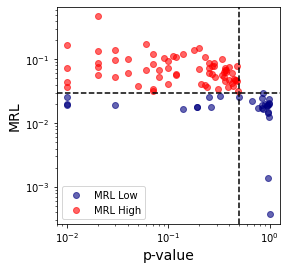

In [616]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(MRL_mx[idxs_MRL_low][:, 1], MRL_mx[idxs_MRL_low][:, 0], color='navy', alpha=0.6, label='MRL Low')
ax.scatter(MRL_mx[idxs_MRL_high][:, 1], MRL_mx[idxs_MRL_high][:, 0], color='red', alpha=0.6, label='MRL High')
ax.axvline(pv_min, ls='--', color='black')
ax.axhline(MRL_min, ls='--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('p-value', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)
ax.legend()

In [602]:
idxs_MRL_high = idxs_MRL_low

## Single TGT pulse

In [617]:
t_ev_sel = sound_events[idxs_tgt_ev][:, 0]  # all TGT
#t_ev_sel = sound_events[idxs_tgt_succ][:, 0]  # TGT succ only

psth_mx = np.zeros([len(units_to_plot), bc - 1])
for i, unit_name in enumerate(units_to_plot):
    bins, psth = get_spike_counts(spike_times[unit_name], t_ev_sel, hw=hw, bin_count=bc)
    
    # scaling
    scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))  # MinMax 
    #scaled = scipystats.zscore(psth)  # z-score
    
    psth_mx[i] = scaled

/tmp/ipykernel_752299/3132596261.py:9: RuntimeWarning: invalid value encountered in divide
  scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))  # MinMax


In [656]:
# kernels
bin_count = 25

# take only the part after pulse onset
tuned_mx = psth_mx[idxs_MRL_high][:, bin_count:]

# sort by the preferred phase to the pulse onset
peak_fr_pos = np.argmax(tuned_mx, axis=1)
idxs_sort_tgt = np.argsort(peak_fr_pos)

# sorted
tuned_mx_sort = tuned_mx[idxs_sort_tgt]

# 1D smoothing
tuned_mx_sm1D = np.zeros_like(tuned_mx)
for i, row in enumerate(tuned_mx_sort):
    tuned_mx_sm1D[i] = smooth_gaussian(row, 20)

# 2D smoothing
kernel = gaussian_kernel_2D(1.0)
tuned_mx_sm2D = signal.convolve2d(tuned_mx_sort, kernel, mode='same')

# shuffle
tuned_mx_shuf = np.random.default_rng().permuted(tuned_mx, axis=1)

# reverse
tuned_mx_rev = tuned_mx[np.flip(idxs_sort_tgt)]

# rolled to the middle
roll_by = -1 * (peak_fr_pos - int(bin_count/2))
tuned_mx_mid = np.zeros_like(tuned_mx)
for i, row in enumerate(tuned_mx):
    tuned_mx_mid[i] = np.roll(tuned_mx[i], roll_by[i])

In [667]:
kernels = [tuned_mx, tuned_mx_sort, tuned_mx_rev, tuned_mx_mid, \
            tuned_mx_sm1D, tuned_mx_sm2D, tuned_mx_shuf]
titles = ['Unsorted', 'Sorted', 'Reversed', 'Rolled to middle', \
          'Sorted smoothed 1D', 'Sorted smoothed 2D', 'Shuffle']

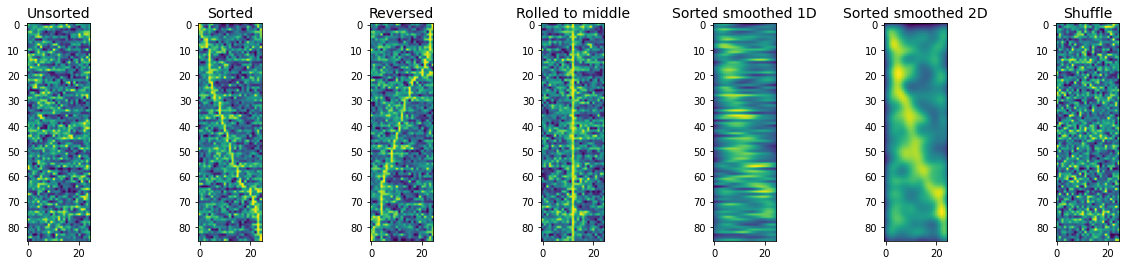

In [668]:
rows = 1
cols = len(kernels)
fig, axes = plt.subplots(1, cols, figsize=(3*cols, 4))

for i, ax in enumerate(axes):
    ax.imshow(kernels[i])
    ax.set_title(titles[i], fontsize=14)

## TGT full

In [661]:
hw_e, bc_e = 10.0, 2001

psth_mx_ext = np.zeros([len(units_to_plot), bc_e - 1])
for i, unit_name in enumerate(units_to_plot):
    bins, psth = get_spike_counts(spike_times[unit_name], \
                      sound_events[idxs_tgt_first_ev][:, 0], hw=hw_e, bin_count=bc_e)

    # scaling
    scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))
    #scaled = scipystats.zscore(psth)
    psth_mx_ext[i] = scaled
    
# take only MRL high units after TGT entrance
tuned_mx_ext = psth_mx_ext[idxs_MRL_high]  #[:, int((bc_e - 1)/2):]
tuned_mx_ext_sort = tuned_mx_ext[idxs_sort_tgt]

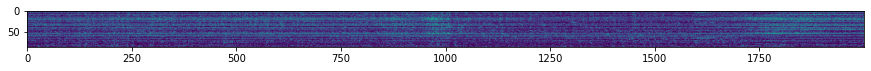

In [662]:
fig, ax = plt.subplots(1,1, figsize=(15, 3))

ax.imshow(tuned_mx_ext_sort)
#ax.set_xlim(200,300)

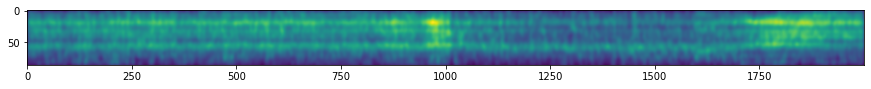

In [663]:
kernel = gaussian_kernel_2D(0.2)
tuned_mx_ext_sm = signal.convolve2d(tuned_mx_ext_sort, kernel, mode='same')

fig, ax = plt.subplots(1,1, figsize=(15, 1))

ax.imshow(tuned_mx_ext_sm, aspect='auto')
#for i in np.arange(0, duration*200, 25):
#    ax.axvline(i, color='white', lw=1, ls='--')
#ax.set_xlim(0, 500)

(1000.0, 1600.0)

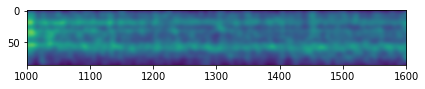

In [664]:
fig, ax = plt.subplots(1,1, figsize=(15, 1))

ax.imshow(tuned_mx_ext_sm)
ax.set_xlim(1000, 1600)

## Cross correlation in TGT

In [669]:
matrices_ext = [tuned_mx_ext_sort]

signals = []
for mx_ext in matrices_ext:
    for kernel in kernels:
        conv_mx = np.zeros_like(mx_ext)
        for i, row in enumerate(mx_ext):
            conv_mx[i] = np.correlate(row, kernel[i], 'same') / kernel.sum()

        signals.append(conv_mx.mean(axis=0))

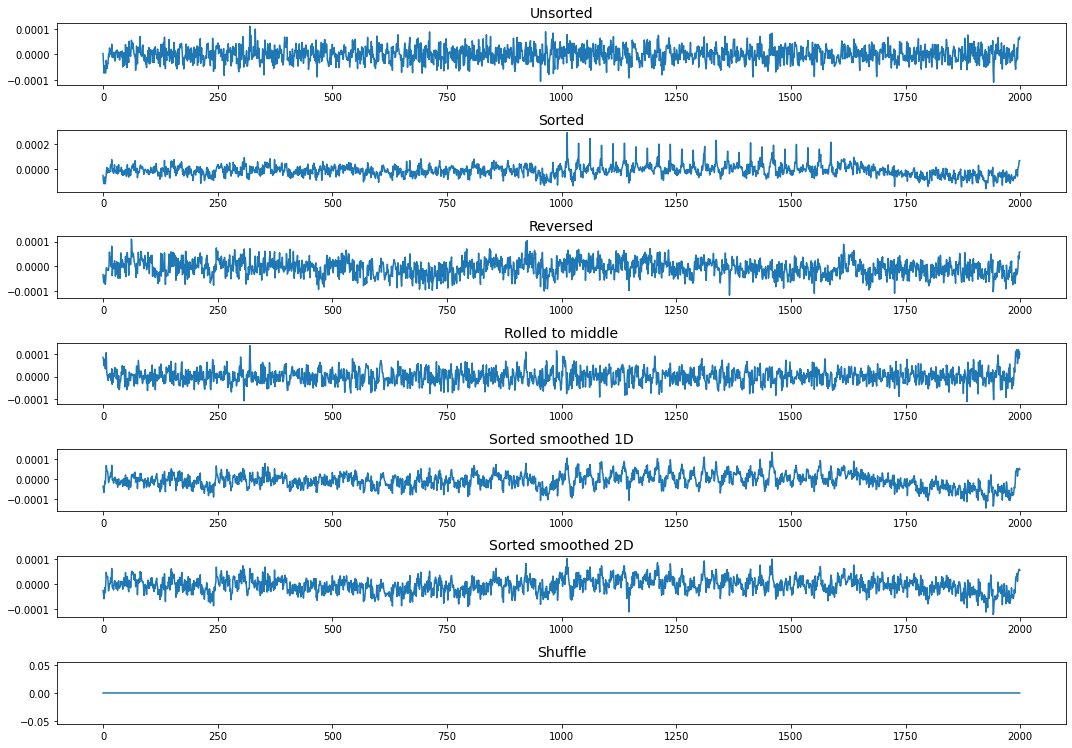

In [671]:
fig, axes = plt.subplots(len(signals), 1, figsize=(15, 1.5*len(signals)))

for i, sig in enumerate(signals):
    axes[i].plot(sig - signals[6])
    axes[i].set_title(titles[i], fontsize=14)
    
fig.tight_layout()

In [672]:
# 1. do shuffle control: 
# - shuffle original tuned_mx_ext 100 times and compute 
#    100 CCR_mx correlated with tuned_mx_sort kernel
# - 100 means of these CCRs would allow to compute percentiles
# - think of when/how subtract the baseline CCR taken from shuffled kernel

#unit_AM_shuf = np.random.default_rng().permuted(unit_AM, axis=1)

In [ ]:
# 2. Provide example from other areas
# - A1
# - PPC
# - Thalamus

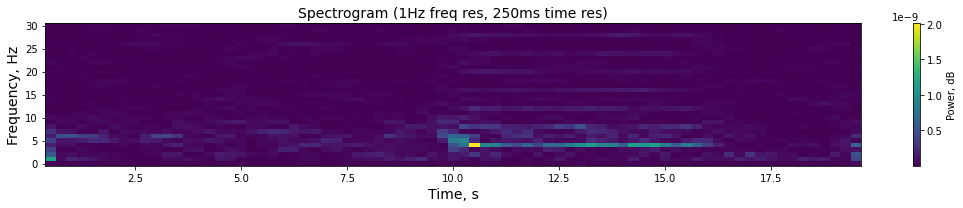

In [628]:
fs = 100  # sampling frequency
duration = 20  # seconds
nperseg = 100       # 100 samples = 1 second → gives 1 Hz freq resolution
noverlap = 75  

f, t_spec, Sxx = signal.spectrogram(sig_nobase, 100, nperseg=nperseg, noverlap=noverlap)

# Select only 0–30 Hz
freq_mask = f <= 30

fig, ax = plt.subplots(figsize=(15, 3))
im = ax.pcolormesh(t_spec, f[freq_mask], Sxx[freq_mask, :], shading='auto')
ax.set_ylabel('Frequency, Hz', fontsize=14)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_title('Spectrogram (1Hz freq res, 250ms time res)', fontsize=14)
fig.colorbar(im, label='Power, dB')
fig.tight_layout()

## Filter the signal and get phase from Hilbert

In [388]:
# bandpass filter 3 - 5 Hz
low_cut, high_cut = 3, 5  # Hz
#low_cut, high_cut = 1, 29  # Hz
s_rate = 100
sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
sig_filt = signal.sosfiltfilt(sos, sig_nobase)

# hilbert transform
analytic_signal = signal.hilbert(sig_filt)  
amplitude_envelope = np.abs(analytic_signal)  # amplitude envelope
instantaneous_phase = np.angle(analytic_signal)  # instantaneous phase

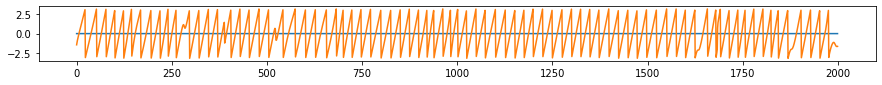

In [389]:
fig, ax = plt.subplots(1, 1, figsize=(15, 1))
ax.plot(sig_filt)
ax.plot(instantaneous_phase)

In [456]:
# - remove state units and see how the activity changes
# - apply it to all units. Is the sequence still present?
# - look at covariance matrix. where are these units? How much are they correlated?

## Alternative to get unit mx aligned to TGT

In [73]:
duration = 6  # seconds
bin_size = 0.01  # 10 ms bins
t_bins = np.arange(0, duration + bin_size, bin_size)  # 0 to 6 seconds, 10 ms bins
tgt_unit_mx = np.zeros([len(units_to_plot), len(t_bins) - 1])

for i, unit_name in enumerate(units_to_plot):
    s_times = spike_times[unit_name]

    # collect all spike times in TGT success
    # align spike times to the first pulse onset
    spk_times_in_tgt = []
    for t_pulse in tgt_first_t:
        spk_t = s_times[(s_times > t_pulse) & (s_times < t_pulse + duration)]
        if len(spk_t) > 0:
            spk_times_in_tgt += list(spk_t - t_pulse)
    
    strain = np.histogram(spk_times_in_tgt, bins=t_bins)[0]
    scaled = (strain - np.min(strain)) / (np.max(strain) - np.min(strain))
    tgt_unit_mx[i] = scaled

/tmp/ipykernel_752299/764705798.py:18: RuntimeWarning: invalid value encountered in divide
  scaled = (strain - np.min(strain)) / (np.max(strain) - np.min(strain))


(300.0, 600.0)

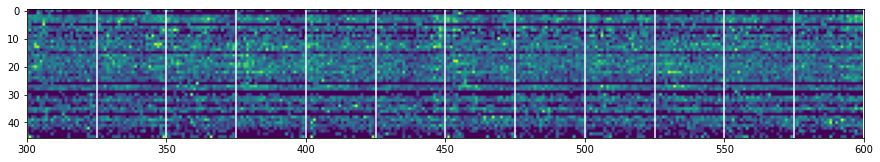

In [110]:
tgt_unit_MRL_mx = tgt_unit_mx[idxs_MRL_high][sort_idxs]

fig, ax = plt.subplots(1,1, figsize=(15, 3))
ax.imshow(tgt_unit_MRL_mx)
for i in np.arange(0, duration*100, 25):
    ax.axvline(i, color='white')
    
ax.set_xlim(300, 600)

In [99]:
test_mx = np.zeros_like(tuned_mx)

for i, row in enumerate(tgt_unit_MRL_mx):
    bouts = np.array([row[x:x+25] for x in np.arange(0, 600, 25)])
    test_mx[i] = bouts.mean(axis=0)

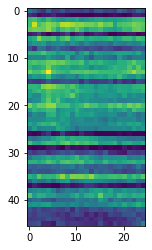

In [100]:
plt.imshow(test_mx)